## Simple approaches to solving the IOT problem

I've done some of my own experiments using PyTorch -- jax and numpyro is cleaner, because , but I kept getting weird Tracer errors from the Sinkhorn algorithm, so for the initial experiments I've decided just writing everything myself gives us more control until we've got the numerics under control, and then we can just switch back.

### 1. Solving the inverse problem with a neural net

Let's first see if we can solve the unbalanced inverse problem with a neural net, and then move on to constructing a sampler. To do this I assume we observe the transport plan $\mathbf{T}$, and the unbalanced marginals $\boldsymbol{\mu}$ and $\boldsymbol{\nu}$, where $\boldsymbol{\mu} \neq \sum_j T_{ij}$, $\boldsymbol{\nu} \neq \sum_i T_{ij}$. We use the following loss function to perform gradient descent:

Let $\hat{\mathbf{T}} = \mathbf{\hat{A}} \exp(-\hat{\mathbf{C}}/\epsilon) \mathbf{\hat{B}}$ be the inferred transport plan, where $\mathbf{\hat{C}}$ is an estimate of the cost matrix and $\mathbf{\hat{A}}$ and $\mathbf{\hat{B}}$ the marginal constraints we obtain from the Sinkhorn algorithm. Then the loss is given by

$J = \Vert \mathbf{\hat{T}} - \mathbf{T} \Vert_p + \Vert \hat{\boldsymbol{\mu}} - \boldsymbol{\mu} \Vert_p + \Vert \hat{\boldsymbol{\nu}} - \boldsymbol{\nu} \Vert_p$.

In a first step, we will let $\boldsymbol{\hat{\mu}} = \sum_j \hat{T}_{ij}$ (and similarly $\boldsymbol{\hat{\nu}}$); in other words, I will not be sampling the marginals, but rather calculating them directly from the inferred transport plan. In a second step, we will also sample the marginals. I will use $p=2$ for all calculations. Calculating the gradient of the loss function thus requires auto-diffing through the Sinkhorn algorithm, for which I've just implemented a quick PyTorch version below:

In [5]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [6]:
from typing import Tuple
def Sinkhorn_torch(a: torch.Tensor, 
                   b: torch.Tensor, 
                   cost_mat: torch.Tensor, 
                   *, 
                   n_iter: int = 100, 
                   eps: float = 1, 
                   requires_gradient: bool = True) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    
    """ Quick pytorch implementation of the basic Sinkhorn algorithm.
    Args:
      - a, b: target marginals
      - cost_mat: cost matrix
      - n_iter: number of iterations to perform
      - eps: epsilon value for the regularisation
      - requires_gradient: whether the marginal constraints require differentiation
    
    Returns: tuple of marginal constraints
    """
    # Initial values
    m = torch.ones_like(a)
    m.requires_gradient=requires_gradient
    n = torch.ones_like(b)
    n.requires_gradient=requires_gradient

    # Exp of cost matrix
    T = torch.exp(-cost_mat/eps)

    # Iterate Sinkhorn algorithm
    for _ in range(n_iter):
        n = b / torch.matmul(T.transpose(0, 1), m).transpose(0, 1)
        m = a / torch.matmul(T, n.transpose(0, 1))
    
    return m, n

def marginals_torch(m, n, cost_mat, *, eps: float = 1) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    """ Calculates the transport plan and marginals given a cost matrix and marginal constraint diagonals (Sinkhorn output) """
    
    # Exp of cost matrix
    T = torch.exp(-cost_mat/eps)

    # Transport plan
    T_pred = torch.matmul(torch.matmul(torch.diag(m.flatten()), T), torch.diag(n.flatten()))

    # Marginals
    mu_pred, nu_pred = T_pred.sum(dim=1, keepdim=True), T_pred.sum(dim=0, keepdim=True)

    return mu_pred, nu_pred, T_pred

Let's generate a random cost matrix $\mathbf{C}$ and some slightly unbalanced marginals $\boldsymbol{\mu}$ and $\boldsymbol{\nu}$:

In [7]:
M, N = 5, 5
C = torch.rand(M, N)
T_true = torch.exp(-C)
mu, nu = T_true.sum(dim=1, keepdim=True), T_true.sum(dim=0, keepdim=True)
mu, nu = mu + torch.normal(0, 0.1, mu.shape), nu + torch.normal(0, 0.1, nu.shape)

Let's initialise a neural network that outputs a predicted cost matrix $\hat{\mathbf{C}}$. We will initialise it with a uniform prior on $[0, 1]$:

In [8]:
from _neural_net import NeuralNet
net = NeuralNet(
    input_size=N + M,
    output_size=N * M,
    num_layers=5,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='relu', layer_specific={-1: 'abs'}),
    biases=dict(default=None),
    prior=dict(distribution='uniform', parameters=dict(lower=0, upper=1))
)

In [9]:
losses, predictions = [], []

def loss_function(input):
    
    # Get the predicted marginals and transport plan
    m, n = Sinkhorn_torch(mu, nu, input, n_iter=100)
    mu_pred, nu_pred, T_pred = marginals_torch(m, n, input)

    # Calculate the loss
    return torch.nn.functional.mse_loss(T_pred, T_true, reduction='sum') + torch.nn.functional.mse_loss(mu_pred, mu, reduction='sum') \
       + torch.nn.functional.mse_loss(nu_pred, nu, reduction='sum')
    
def epoch():

    # Generate a predicted cost matrix
    C_pred = torch.reshape(net(torch.rand(M+N, requires_grad=True)), (M, N))
    loss = loss_function(C_pred)
    
    loss.backward()
    net.optimizer.step()
    net.optimizer.zero_grad()

    losses.append(loss.detach())
    predictions.append(C_pred.detach())

In [10]:
# Train the neural net
n_iterations = 4000
for _ in tqdm(range(n_iterations)):
    epoch()

100%|██████████████████████████████████████| 4000/4000 [00:30<00:00, 129.81it/s]


Let's see what the neural network converged to:

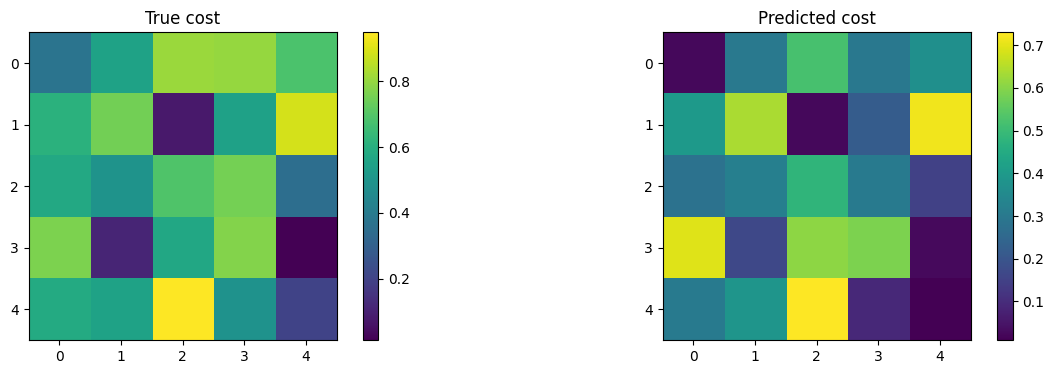

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))
for idx, d in enumerate([('True cost', C ), 
                          ('Predicted cost', predictions[-1])]):
    title, data = d
    im = axs[idx].imshow(data)
    axs[idx].set_title(title)
    fig.colorbar(im, ax=axs[idx])

plt.show()

Now let's plot the marginals over the prediction. Since we have the loss function at each sampled cost network, we can calculate the (unnormalised) likelihood $\rho(\mathbf{C}) \sim \exp -J(\mathbf{\hat{C}})$. Since any given cost matrix may be sampled more than once, we bin over the sampled space and take the average value of $\rho$ over each bin (not the total count!)

(1, 2)
(0, 2)
(0, 1)


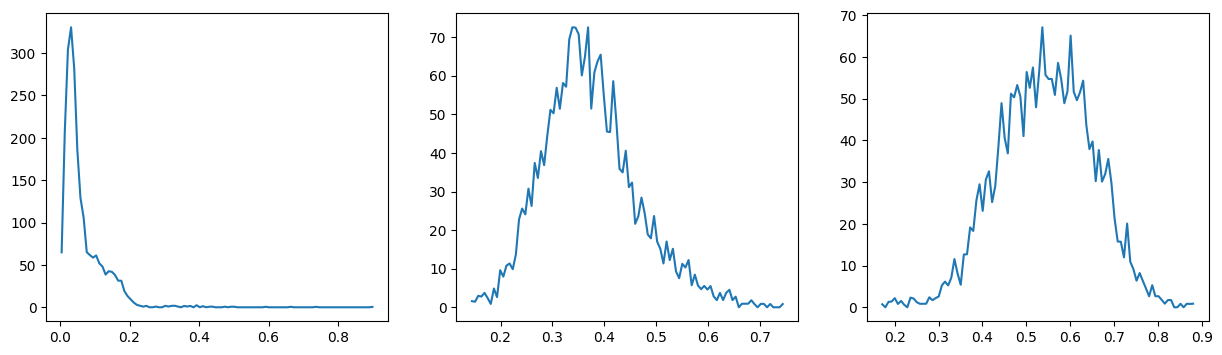

In [16]:
import seaborn as sns
import scipy.stats
fig, axs = plt.subplots(figsize=(15, 4), ncols=3)
samples = torch.reshape(torch.stack(predictions), (-1, M*N))[:, 0:3]
probabilities = torch.exp(-torch.tensor(losses))

joint = scipy.stats.binned_statistic_dd(samples.numpy(), probabilities.numpy(), bins=100, statistic='mean')
vals = np.arange(3)
for i in vals:
    marginals = np.nansum(joint.statistic, axis=tuple(vals[vals!=i]))
    axs[i].plot(0.5*(joint.bin_edges[i][1:]+joint.bin_edges[i][:-1]), marginals)
    # axs[i].vlines(C, colorr='red', linestyle='dotted')
# ax.scatter(np.arange(M*N), np.reshape(C, (-1, M*N)), marker='o', zorder=10, c='red')
# ax.set_title("Predicted vs true cost")

Text(0.5, 1.0, 'Predicted vs true cost')

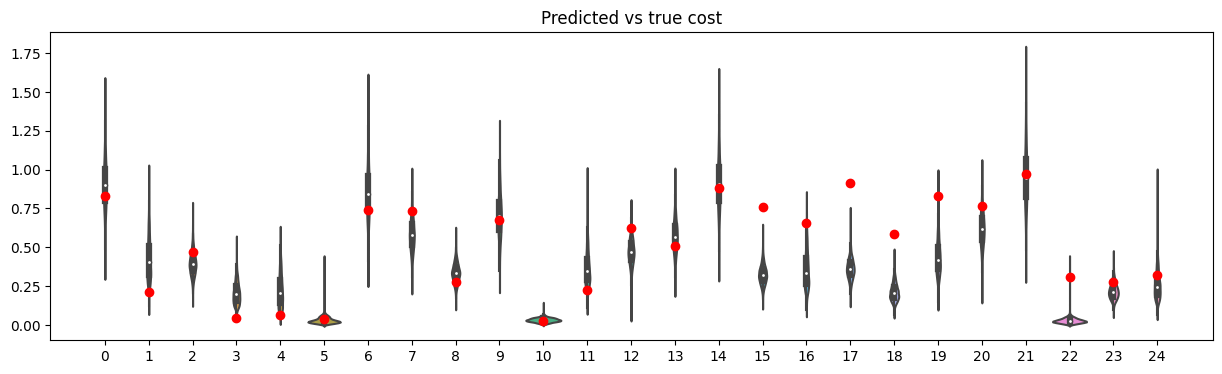

In [11]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 4))
sns.violinplot(torch.reshape(torch.stack(predictions), (n_iterations, M*N)), ax=ax)
ax.scatter(np.arange(M*N), np.reshape(C, (-1, M*N)), marker='o', zorder=10, c='red')
ax.set_title("Predicted vs true cost")

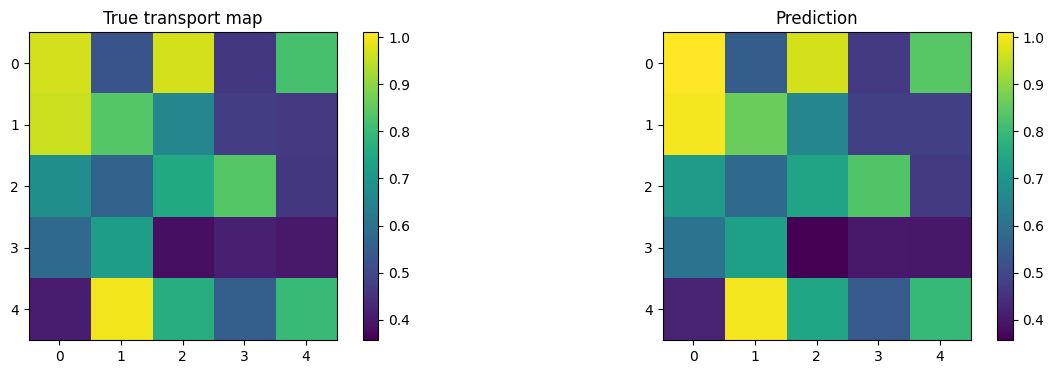

In [39]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))
m, n = Sinkhorn_torch(mu, nu, predictions[-1])
mu_pred, nu_pred, T_pred = marginals_torch(m, n, predictions[-1])
for idx, d in enumerate([('True transport map', T_true), ('Prediction', T_pred)]):
    title, data = d
    im = axs[idx].imshow(data, vmin=torch.min(torch.min(T_true), torch.min(T_pred)), vmax=torch.max(torch.max(T_true), torch.max(T_pred)))
    axs[idx].set_title(title)
    fig.colorbar(im, ax=axs[idx])

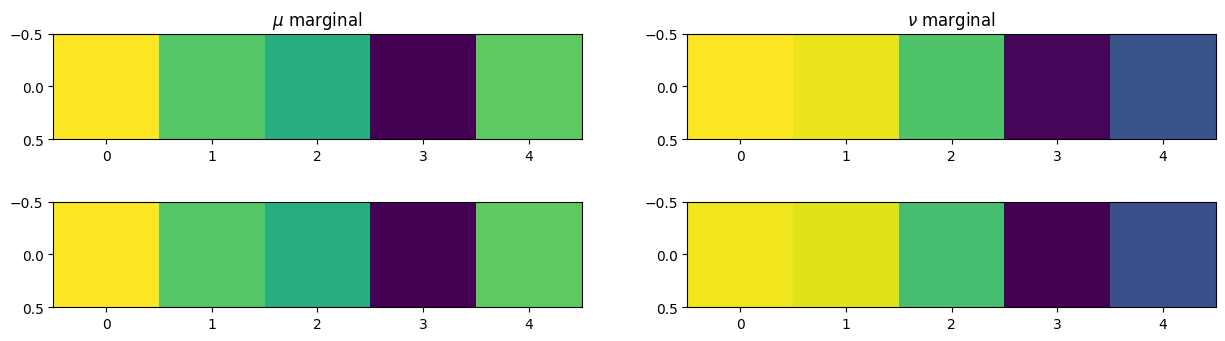

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15, 4))

vmin_mu, vmax_mu = torch.min(torch.min(mu), torch.min(mu_pred)), torch.max(torch.max(mu), torch.max(mu_pred))
vmin_nu, vmax_nu = torch.min(torch.min(nu), torch.min(nu_pred)), torch.max(torch.max(nu), torch.max(nu_pred))

axs[0, 0].imshow(mu.transpose(0, 1), vmin=vmin_mu, vmax=vmax_mu)
axs[0, 0].set_title(r'$\mu$ marginal')
axs[0, 1].imshow(nu, vmin=vmin_nu, vmax=vmax_nu)
axs[0, 1].set_title(r'$\nu$ marginal')

axs[1, 0].imshow(mu_pred.transpose(0, 1), vmin=vmin_mu, vmax=vmax_mu)
axs[1, 1].imshow(nu_pred, vmin=vmin_nu, vmax=vmax_nu)

Text(0.5, 1.0, 'Loss plot')

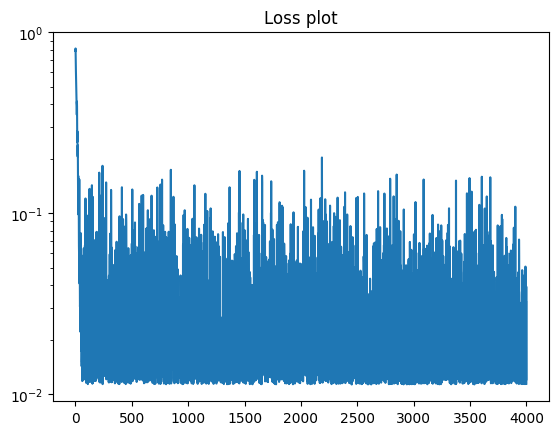

In [41]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
ax.set_yscale('log')
ax.set_title("Loss plot")

### 2. MALA
Now let's use the same loss function for a Metropolis-adjusted Langevin sampler:

In [430]:
# Initialise a Langevin sampler
from _langevin import MetropolisAdjustedLangevin
from typing import Any

class IOT_Langevin_sampler(MetropolisAdjustedLangevin):
    """
    A Metropolis-adjusted Langevin sampler (inherits from the base class given in the _langevin.py file)
    """

    def __init__(
            self,
            *,
            true_data: torch.Tensor = None,
            init_guess: Any,
            lr: float = 1e-2,
            lr_final: float = 1e-4,
            max_itr: float = 1e4,
            beta: float = 0.99,
            Lambda: float = 1e-15,
            centered: bool = False,
            write_start: int = 1,
            write_every: int = 1,
            batch_size: int = 1,
            a: torch.Tensor,
            b: torch.Tensor,
            T_true: torch.Tensor = None,
            C_true: torch.Tensor = None,
            **__,
    ):
        super(IOT_Langevin_sampler, self).__init__(
            true_data=true_data, init_guess=init_guess, lr=lr, lr_final=lr_final,
            max_itr=max_itr, beta=beta, Lambda=Lambda, centered=centered, write_start=write_start,
            write_every=write_every, batch_size=batch_size
        )

        # Save the marginals
        self.a = a
        self.b = b
        self.M = a.shape[0]
        self.N = b.shape[1]
        self.T_true = T_true
        self.C_true = C_true

        # Dataset for the log-likelihood
        self.dset_loss = np.empty((0,))

        # Create datasets for the predicted cost matrix and predicted marginals
        self.dset_cost_matrix = np.empty((0, self.M, self.N))
        self.dset_marginal_1 = np.empty((0, self.M))
        self.dset_marginal_2 = np.empty((0, self.N))

        # Calculate the initial values of the loss and its gradient
        self.loss[0] = self.loss_function(self.x[0])
        self.loss[1].data = self.loss[0].data

        self.grad[0].data = torch.autograd.grad(
            self.loss[0], [self.x[0]], create_graph=False
        )[0].data
        self.grad[1].data = self.grad[0].data

    def loss_function(self, C_pred):
        """ Returns the L2-loss on the marginals of a given predicted cost matrix C. The factor 1000 is used to prevent the preconditioner
        getting very large, as it is inversely proportional to the gradient.

        :param C_pred: predicted cost matrix
        """
        return 1000*loss_function(torch.reshape(C_pred, (self.M, self.N)))
        
    def write_data(self):
        if self.time > self.write_start and self.time % self.write_every == 0:
            self.dset_loss.resize(self.dset_loss.shape[0] + 1, *self.dset_loss.shape[1:])
            self.dset_loss[-1] = self.loss[0].detach().numpy()

            self.dset_cost_matrix.resize(self.dset_cost_matrix.shape[0] + 1, *self.dset_cost_matrix.shape[1:])
            self.dset_cost_matrix[-1, :] = torch.reshape(self.x[0].detach(), (self.M, self.N))

            m, n = Sinkhorn_torch(self.a, self.b, torch.reshape(self.x[0].detach(), (self.M, self.N)), n_iter=100)
            mu_pred, nu_pred, _ = marginals_torch(m, n, torch.reshape(self.x[0].detach(), (self.M, self.N)))
                                     
            self.dset_marginal_1.resize(self.dset_marginal_1.shape[0] + 1, *self.dset_marginal_1.shape[1:])
            self.dset_marginal_1[-1, :] = torch.flatten(mu_pred)

            self.dset_marginal_2.resize(self.dset_marginal_2.shape[0] + 1, *self.dset_marginal_2.shape[1:])
            self.dset_marginal_2[-1, :] = torch.flatten(nu_pred)

In [456]:
from tqdm import tqdm
sampler = IOT_Langevin_sampler(
    init_guess=C.flatten(), #np.random.rand(M*N, ),
    a=mu,
    b=nu,
    T_true=torch.reshape(T_true, (M * N,)),
    C_true=torch.reshape(C, (M * N,)),
    write_start=500, # burn-in
    write_every=1,
)

for _ in tqdm(range(20000)):
    sampler.sample()
    sampler.write_data()

100%|████████████████████████████████████| 20000/20000 [01:27<00:00, 227.95it/s]


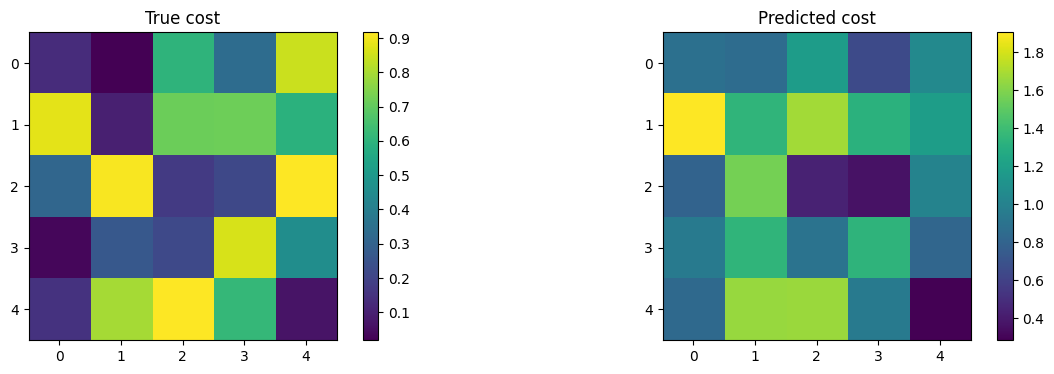

In [452]:
C_pred = (sampler.dset_cost_matrix)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))
for idx, d in enumerate([('True cost', C),
                         ('Predicted cost', C_pred.mean(axis=0))]):
    title, data = d
    im = axs[idx].imshow(data)
    axs[idx].set_title(title)
    fig.colorbar(im, ax=axs[idx])

Text(0.5, 1.0, 'Cost matrix')

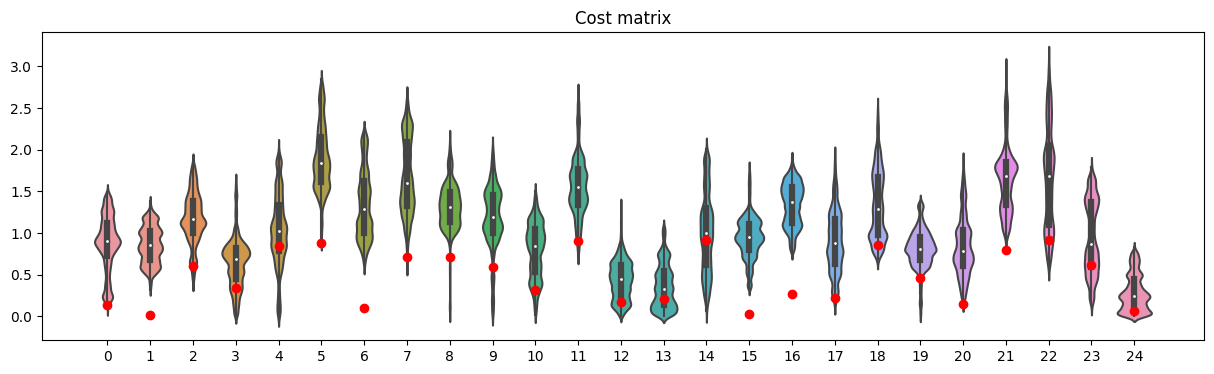

In [453]:
fig, ax = plt.subplots(figsize=(15, 4))

import seaborn as sns
sns.violinplot(np.reshape(C_pred, (-1, M*N)), ax=ax)
ax.scatter(np.arange(M*N), np.reshape(C, (-1, M*N)), marker='o', zorder=10, c='red')
ax.set_title("Cost matrix")

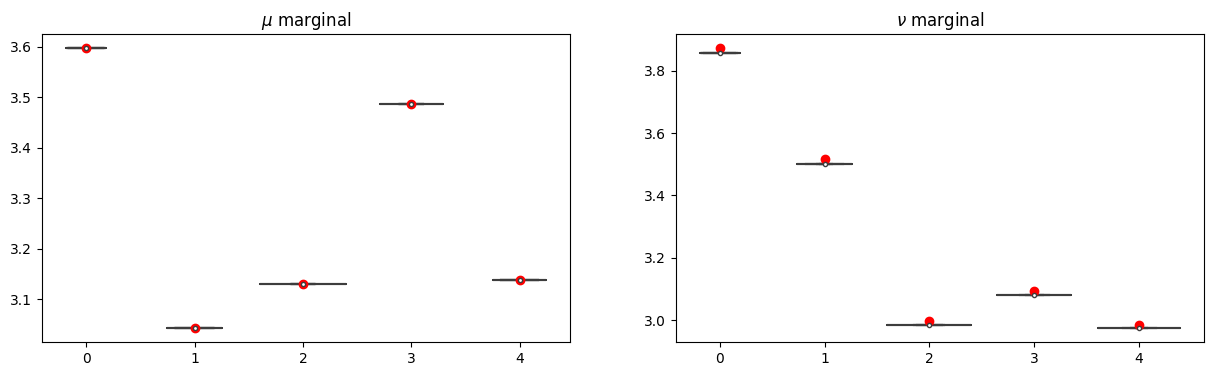

In [449]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
for idx, d in enumerate([(r'$\mu$ marginal', sampler.dset_marginal_1, mu), (r'$\nu$ marginal', sampler.dset_marginal_2, nu)]):
    title, dset, true_marginal = d
    sns.violinplot(dset, ax=axs[idx])
    axs[idx].set_title(title)
    axs[idx].scatter(np.arange(len(true_marginal.flatten())), true_marginal.flatten(), c='red', marker='o')

Text(0.5, 1.0, 'Loss over time')

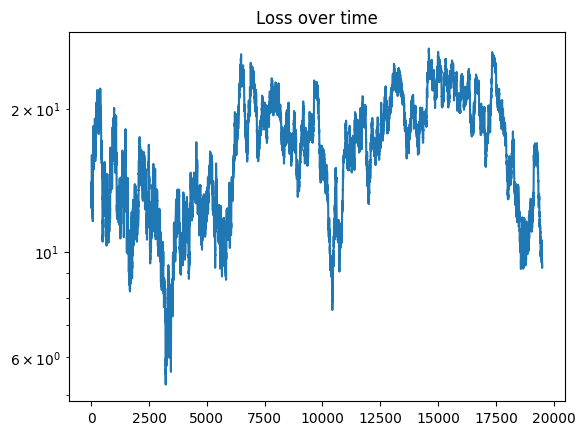

In [458]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(sampler.dset_loss)), sampler.dset_loss)
ax.set_yscale('log')
ax.set_title("Loss over time")